# Open problems - Single cell perturbations
## Pitfalls of the MRRMSE evaluation metric
#### by Antoine Passemiers

---

In this short notebook, we discuss the limitations of the performance metric used in this competition, namely the Mean Rowwise Root Mean Squared Error (MRRMSE). The metric is defined as:
$$
    \text{MRRMSE} = \frac{1}{R} \sum_{i=1}^R \left( \frac{1}{n} \sum_{j=1}^n \left( y_{ij} - \hat{y}_{ij} \right)^2 \right)^{1/2},
$$
where $y_{ij}$ is the ground-truth DE value for gene $j$ in sample $i$, $\hat{y}_{ij}$ is the corresponding prediction, $n=18211$ is the total number of genes and $R$ is the dataset size.

We propose an variant of this metric which accounts for the significance of DE values:

$$
    \text{MRRMSE}_{\text{corrected}} = \frac{1}{R} \sum_{i=1}^R \left( \frac{1}{n} \sum_{j=1}^n \left[ \left\vert y_{ij} \right\vert > \alpha \right] \left( y_{ij} - \hat{y}_{ij} \right)^2 \right)^{1/2},
$$

where $[\cdot]$ denotes Iverson brackets, and $\alpha$ is a significance threshold. This threshold is used to disregard non-significant genes which would otherwise contribute to the MRRMSE with random error terms. We set $\alpha$ at $\log_{10}(0.01) = 2$ for this purpose, where $0.01$ is an widely-used cutoff for $p$-values.

Let's note that the metric could have been improved further by also considering the cases where the ground-truth is non-significant but the prediction is.

In [2]:
import os
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Data location
DATA_FOLDER = '/kaggle/input/open-problems-single-cell-perturbations/'

# Cell types for which all compounds are available in training set
TRAIN_CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']

# Cell types for which some compounds are available in test set
TEST_CELL_TYPES = ['Myeloid cells', 'B cells']

# Load DE data, as well as the cell type, compound and SMILES for each row
df = pd.read_parquet(os.path.join(DATA_FOLDER, 'de_train.parquet'))
cell_types = df['cell_type']
sm_names = df['sm_name']
all_smiles = df['SMILES']

# Convert Pandas dataframe to NumPy array
for col_name in ['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control']:
    df.drop(col_name, axis=1, inplace=True)
data = df.to_numpy(dtype=float)

Let's now define the metrics to be compared, namely MRRMSE and its revised version.

In [5]:
def mrrmse(x: np.ndarray, y: np.ndarray) -> float:
    """Mean Rowwise Root Mean Squared Error (MRRMSE) metric.
    
    Args:
        x: Ground-truth data matrix, of shape `(n_samples, n_genes)`.
        y: Prediction matrix, of shape `(n_samples, n_genes)`.
    
    Returns:
        MRRMSE evaluation.
    """
    return float(np.mean(np.sqrt(np.mean(np.square(x - y), axis=1))))


def sig_mrrmse(x: np.ndarray, y: np.ndarray) -> float:
    """Revised version of theMean Rowwise Root Mean Squared Error (MRRMSE) metric,
    which accounts for the non-significance of some of the genes.
    
    Args:
        x: Ground-truth data matrix, of shape `(n_samples, n_genes)`.
        y: Prediction matrix, of shape `(n_samples, n_genes)`.
    
    Returns:
        Corrected MRRMSE evaluation.
    """
    threshold = -np.log10(0.01)  # Significance threshold (=2)
    weights = np.ones(x.shape)
    weights[np.abs(x) < threshold] = 0  # Disregard ground-truth DE values that are not significant
    diff = weights * np.square(x - y)
    return np.mean(np.sqrt(np.mean(diff, axis=1)))

We now simulate 3 different types of estimators:
- The first estimator systematically and perfectly predicts the expected DE when the ground-truth DE is lower than 2 in magnitude, assuming that genes below that threshold do not carry any biological signal. Indeed, for non-significant genes, the estimator should fail at predicting their DE values since the latter are driven by random chance and potentially artifactual patterns. Therefore, for ground-truth DE values below 2 in absolute value, estimator predicts a random uniform value in the [-2, 2] range, reflecting the impossibility to accurately predict DE for these genes.
- The second estimator is designed in exactly the same way, but based on a cutoff of 3 instead, and predicting random uniform values in the [-3, 3] range when DE is below 3 in magnitude.
- The last estimator is a simple baseline approach which systematically predicts 0.

In [8]:
# Ground-truth
y_true = data

additive_noise = np.random.rand(*data.shape) * 4 - 2
mask = (np.abs(data) < 2)
y_pred2 = np.copy(data)
y_pred2[mask] = additive_noise[mask]

# Predictor that 
additive_noise = np.random.rand(*data.shape) * 6 - 3
mask = (np.abs(data) < 3)
y_pred3 = np.copy(data)
y_pred3[mask] = additive_noise[mask]


y_baseline = np.tile(np.mean(y_true, axis=0)[np.newaxis, :], (len(data), 1))
y_zero = np.zeros(data.shape)

print('MRRMSE')
print('------')
print(f'Noisy estimator (cutoff=2): {mrrmse(y_true, y_pred2)}')
print(f'Noisy estimator (cutoff=3): {mrrmse(y_true, y_pred3)}')
print(f'Baseline zero: {mrrmse(y_true, y_zero)}')
print('')
print('Corrected MRRMSE')
print('----------------')
print(f'Noisy estimator (cutoff=2): {sig_mrrmse(y_true, y_pred2)}')
print(f'Noisy estimator (cutoff=3): {sig_mrrmse(y_true, y_pred3)}')
print(f'Baseline zero: {sig_mrrmse(y_true, y_zero)}')

MRRMSE
------
Noisy estimator (cutoff=2): 1.2651475068435494
Noisy estimator (cutoff=3): 1.8452089788370432
Baseline zero: 1.2814530984649364

Corrected MRRMSE
----------------
Noisy estimator (cutoff=2): 0.0
Noisy estimator (cutoff=3): 0.41280016743984177
Baseline zero: 0.979080626924946


With MRRMSE, the first estimator barely outperforms the zero, although perfectly predicting strong biological signals. More strikingly, the second estimator performs worse than the baseline. When using the revised version however, both estimators now outperform the baseline. We showed that this simple change in the definition of the metric can make it robust to the noise introduced by the bulk of non-significant DE values.

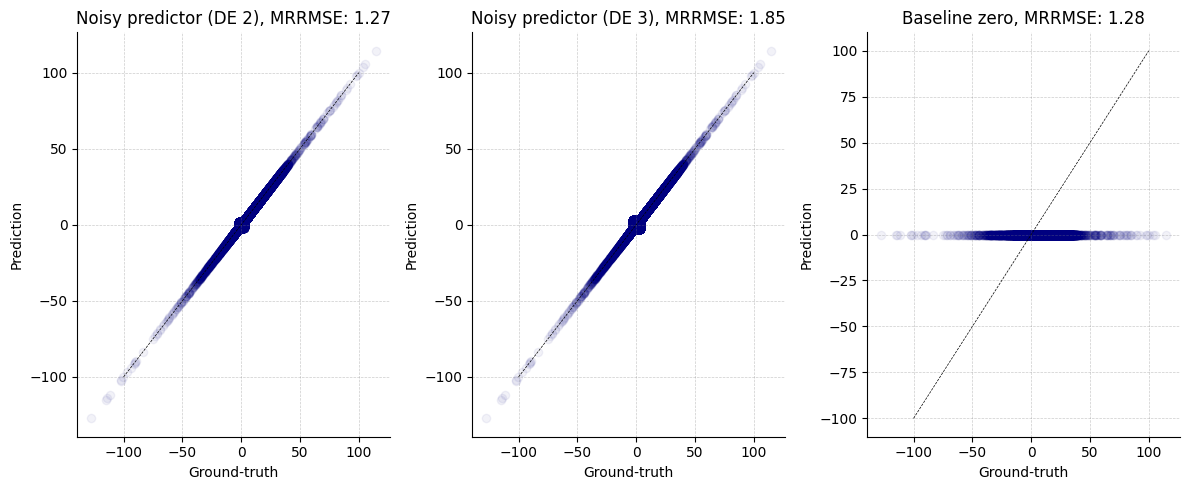

In [11]:
step = 10  # Subsetting the data points to avoid unreasonable waiting times
plt.figure(figsize=(12, 5))

# Show the first estimator vs ground-truth
ax = plt.subplot(1, 3, 1)
plt.scatter(y_true.flatten()[::step], y_pred2.flatten()[::step], alpha=0.05, color='navy')
plt.plot([-100, 100], [-100, 100], color='black', linestyle='--', linewidth=0.5)
plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.ylabel('Prediction')
plt.xlabel('Ground-truth')
plt.title(f'Noisy predictor (DE 2), MRRMSE: {mrrmse(y_true, y_pred2):.2f}')

# Show the second estimator vs ground-truth
ax = plt.subplot(1, 3, 2)
plt.scatter(y_true.flatten()[::step], y_pred3.flatten()[::step], alpha=0.05, color='navy')
plt.plot([-100, 100], [-100, 100], color='black', linestyle='--', linewidth=0.5)
plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.ylabel('Prediction')
plt.xlabel('Ground-truth')
plt.title(f'Noisy predictor (DE 3), MRRMSE: {mrrmse(y_true, y_pred3):.2f}')

# Show the third (baseline) estimator vs ground-truth
ax = plt.subplot(1, 3, 3)
plt.scatter(y_true.flatten()[::step], y_zero.flatten()[::step], alpha=0.05, color='navy')
plt.plot([-100, 100], [-100, 100], color='black', linestyle='--', linewidth=0.5)
plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.ylabel('Prediction')
plt.xlabel('Ground-truth')
plt.title(f'Baseline zero, MRRMSE: {mrrmse(y_true, y_zero):.2f}')

plt.tight_layout()
plt.savefig('mrrmse.png', dpi=200)
plt.show()

Based on the scatter plots, it is not acceptable for the baseline to outperform the 2 first predictors, as they clearly correlate with the high real values, which are the only ones putatively carrying a true biological signal.

##### 